# UniversityHack 2021 - Atmira Stock Prediction - Script Producción
-----

In [1]:
import pandas as pd
import numpy as np

import tensorflow as tf

import keras
from keras import models
from keras import activations

from datetime import datetime
from matplotlib import pyplot as plt

from IPython.display import clear_output
import gc
import warnings
warnings.filterwarnings('ignore')

In [2]:
# If you plan to run this notebook, it is recomended you have at least one GPU
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


# Data Preprocessing

Before we do anything with our data, we perform an extensive data preprocessing step according to our EDA findings:

1. Drop the `antiguedad` variable as we do not find it contains sensible data.
2. Change the dates to the correct year we estimate the data is from to match the weekday periodicity missmatch.
3. Scale the visitas x5 for the period preceding 2019-1-24 as we've found that it was tampered with.
4. One-hot encode several fields to improve ML performance
5. Augment our data with weekday and monthly sin/cos periodicty helpers. Will help the ML system detect periodic patterns.

We also run a price filling algorithm on the `Modelar` dataset to fill in the Price of items as specified in the instructions.

In [81]:
def data_preprocessing(df):
    # General cleaning
    df = df.drop_duplicates()
    df.dropna(how='any', inplace=True)
    df = df.drop(['antiguedad'], axis=1, errors='ignore')
    
    # Fix years
    df.loc[df.fecha.dt.year == 2015, "fecha"] = df["fecha"] + pd.offsets.DateOffset(year=2018)
    df.loc[df.fecha.dt.year == 2016, "fecha"] = df["fecha"] + pd.offsets.DateOffset(year=2019)
    
    # Fix visitas
    pre = df.fecha <= datetime(2019,1,24)
    post = df.fecha > datetime(2019,1,24)
    
    df['visitas_scl'] = np.concatenate([
        df[pre].visitas * 5,
        df[post].visitas * 1,
        ], axis=0
    )
    
    # Data Augmentation
    df['dia_atipico_neg'] = (df.dia_atipico == -1).astype(int)
    df['dia_atipico_neu'] = (df.dia_atipico == 0).astype(int)
    df['dia_atipico_pos'] = (df.dia_atipico == 1).astype(int)

    df['estado_no_rotura'] = (df.estado == 'No Rotura').astype(int)
    df['estado_transito'] = (df.estado == 'Transito').astype(int)
    df['estado_rotura'] = (df.estado == 'Rotura').astype(int)
    
    df['categoria_dos'] = df.categoria_dos.astype('str').str.replace('.0','')
    df_categoria_uno_onehot = pd.get_dummies(df.categoria_uno, prefix='categoria_uno_')
    df_categoria_dos_onehot = pd.get_dummies(df.categoria_dos, prefix='categoria_dos_')
    
    df_fe = pd.concat([df, df_categoria_uno_onehot, df_categoria_dos_onehot], axis=1)
    df_fe = df_fe.drop(['estado', 'dia_atipico', 'categoria_uno', 'categoria_dos'], axis=1, errors='ignore')
    
    # Cyclical week and month spinners
    df_weekday = df_fe.fecha.dt.weekday
    df_month = df_fe["fecha"].dt.month + (df_fe["fecha"].dt.day / df_fe["fecha"].dt.days_in_month)
    
    df_fe['weekday_sin'] = np.sin(df_weekday * (2*np.pi/7))
    df_fe['weekday_cos'] = np.cos(df_weekday * (2*np.pi/7))
    df_fe['month_sin'] = np.sin((df_month-1) * (2*np.pi/12))
    df_fe['month_cos'] = np.cos((df_month-1) * (2*np.pi/12))
    
    return df_fe

def data_preprocessing_2(df):
    # General cleaning
    print('Dropping duplicates')
    df = df.drop_duplicates()
    df = df.drop(['antiguedad'], axis=1, errors='ignore')
    
    print('Fixing duplicate entries for campaign days')
    df = df.groupby(['fecha','id']).max().reset_index()
    
    print('Fixing dates')
    df.loc[df.fecha.dt.year == 2015, "fecha"] = df["fecha"] + pd.offsets.DateOffset(year=2018)
    df.loc[df.fecha.dt.year == 2016, "fecha"] = df["fecha"] + pd.offsets.DateOffset(year=2019)
    
    print('Fixing visits')
    pre = df.fecha <= datetime(2019,1,24)
    post = df.fecha > datetime(2019,1,24)
    
    df['visitas_scl'] = np.concatenate([
        df[pre].visitas * 5,
        df[post].visitas * 1,
        ], axis=0
    )
    
    # Data Augmentation
    df['dia_atipico_neg'] = (df.dia_atipico == -1).astype(int)
    df['dia_atipico_neu'] = (df.dia_atipico == 0).astype(int)
    df['dia_atipico_pos'] = (df.dia_atipico == 1).astype(int)

    df['estado_no_rotura'] = (df.estado == 'No Rotura').astype(int)
    df['estado_transito'] = (df.estado == 'Transito').astype(int)
    df['estado_rotura'] = (df.estado == 'Rotura').astype(int)
    
    # Drop the old columns
    df = df.drop(['estado', 'dia_atipico'], axis=1, errors='ignore')
    
    # Prepare categorias for Embedding
    df['categoria_uno'] = pd.Series(list(map(ord, df_modelar.categoria_uno))) - ord('A')+1
    df['categoria_dos'] = df.categoria_dos.fillna(0).astype(int)

    print('One-hot encoding of Category')
    df_categoria_uno_onehot = pd.get_dummies(df.categoria_uno, prefix='categoria_uno_')
    df_categoria_dos_onehot = pd.get_dummies(df.categoria_dos, prefix='categoria_dos_')
    
    df = pd.concat([df, df_categoria_uno_onehot, df_categoria_dos_onehot], axis=1)

    # Cyclical week and month spinners
    df_weekday = df.fecha.dt.weekday
    df_month = df["fecha"].dt.day / df["fecha"].dt.days_in_month
    df_year = (df["fecha"].dt.month - 1) + (df["fecha"].dt.day / df["fecha"].dt.days_in_month)
    
    df['weekday_sin'] = np.sin(df_weekday * (2*np.pi/7))
    df['weekday_cos'] = np.cos(df_weekday * (2*np.pi/7))
    df['month_sin'] = np.sin(df_month * (2*np.pi))
    df['month_cos'] = np.cos(df_month * (2*np.pi))
    df['year_sin'] = np.sin((df_year-1) * (2*np.pi/12))
    df['year_cos'] = np.cos((df_year-1) * (2*np.pi/12))
    
    print('clearing NANs')
    df.dropna(how='any', inplace=True)
    
    return df

def data_preprocessing_fill_price(df):
    total = len(df.id.unique())

    for i, pid in enumerate(df.id.unique()):
        # This product's entries
        df_prod = df[df.id == pid]

        # Fillforward, then back to cover the first few lines
        df_prod = df_prod.fillna(method='ffill').fillna(method='bfill')

        # Save to DF
        df.loc[df_prod.index] = df_prod

        clear_output(wait=True)
        print("Filled %.1f%% of the Dataframe" % (i/total * 100))
        

In [ ]:
df_modelar = pd.read_csv('./data/Modelar_UH2021_filled_precio_2.txt',sep='|', parse_dates=[0])

print(df_modelar.shape)
df_modelar = data_preprocessing_2(df_modelar)
df_modelar[:5]

(4045022, 11)
Dropping duplicates
Fixing duplicate entries for campaign days


In [ ]:
df_estimar = pd.read_csv('./data/Estimar2.txt', parse_dates=[0], sep='|', decimal=',', engine="python")
df_estimar = data_preprocessing_2(df_estimar)

print(df_estimar.shape)
df_estimar[:5]

## Select all columns that appear in both DataFrames

Since not all categories appear in `Estimar`, we perform a set intersect to grab the matching columns. After this we are finally ready to build our model.

In [ ]:
df_modelar_columns = set(df_modelar.columns)
df_estimar_columns = set(df_estimar.columns)
df_common_columns = df_modelar_columns & df_estimar_columns

# Reorder fecha to first column
df_common_columns.remove('fecha')

df_modelar = df_modelar[['fecha'] + list(df_common_columns) + ['unidades_vendidas']]
df_estimar = df_estimar[['fecha'] + list(df_common_columns)]

In [ ]:
df_modelar.to_csv('data/Modelar_UH2021_prod.txt', index=False)
df_estimar.to_csv('data/Estimar2_prod.txt', index=False)

In [4]:
df_modelar = pd.read_csv('data/Modelar_UH2021_prod.txt', parse_dates=[0])
df_estimar = pd.read_csv('data/Estimar2_prod.txt', parse_dates=[0], decimal=',')

In [36]:
df_modelar[df_modelar.campaña == 1]

,fecha,id,visitas,categoria_uno,categoria_dos,precio,campaña,unidades_vendidas,visitas_scl,dia_atipico_neg,...,estado_no_rotura,estado_transito,estado_rotura,categoria_uno_int,weekday_sin,weekday_cos,month_sin,month_cos,year_sin,year_cos
137305,2018-07-04,76356,235,I,290,20.61,1,15,1175,0,...,1,0,0,1,0.974928,-0.222521,0.724793,0.688967,-0.067510,-0.997719
137340,2018-07-04,86736,362,A,16,51.10,1,30,1810,0,...,1,0,0,1,0.974928,-0.222521,0.724793,0.688967,-0.067510,-0.997719
137344,2018-07-04,87000,770,A,46,16.22,1,102,3850,0,...,1,0,0,1,0.974928,-0.222521,0.724793,0.688967,-0.067510,-0.997719
137358,2018-07-04,91226,630,A,16,22.23,1,87,3150,0,...,1,0,0,1,0.974928,-0.222521,0.724793,0.688967,-0.067510,-0.997719
137372,2018-07-04,93984,812,A,23,30.01,1,120,4060,0,...,1,0,0,5,0.974928,-0.222521,0.724793,0.688967,-0.067510,-0.997719
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1683295,2019-07-10,336574,325,H,307,105.10,1,0,325,0,...,1,0,0,5,0.974928,-0.222521,0.897805,-0.440394,-0.168101,-0.985770
1687454,2019-07-11,336574,220,H,307,105.10,1,0,220,0,...,1,0,0,1,0.433884,-0.900969,0.790776,-0.612106,-0.184726,-0.982790
1691613,2019-07-12,336574,235,H,307,105.10,1,0,235,0,...,1,0,0,3,-0.433884,-0.900969,0.651372,-0.758758,-0.201299,-0.979530
1695772,2019-07-13,336574,270,H,307,105.10,1,0,270,0,...,1,0,0,1,-0.974928,-0.222521,0.485302,-0.874347,-0.217814,-0.975990


# Machine Learning Pipeline

We will be using Keras to build a regression Neural Network to predict the target label. The steps will be as follows:

1. Determine the X and y columns
2. Split our data in Train / Test datasets wtih 0.9 / 0.1 weights
3. Transform our data to be easier for the NN to process
4. Sanity check our data before we proceed
5. Define the NN model to use:
    - Layer types
    - Number of neurons per layer
    - Output layer
    - Optimization function
    - Target loss
6. Execute the NN training on a GPU

## Data handling - Train / Test Split

In [47]:
gc.collect()

35

In [5]:
from sklearn.model_selection import train_test_split

X_cols = [
    'id',
    'campaña',
    'dia_atipico_neg', 'dia_atipico_neu', 'dia_atipico_pos',
    'estado_rotura', 'estado_no_rotura', 'estado_transito',
    'precio', 'visitas_scl',
    'weekday_sin', 'weekday_cos',
    'month_sin', 'month_cos',
    'year_sin', 'year_cos',
    'categoria_uno_int',
    'categoria_dos'
]

y_cols = ['unidades_vendidas']

X = df_modelar[X_cols]
y = df_modelar[y_cols]

X = X.astype('float')
y = y.astype('float')

int_cols = ['id', 'categoria_uno_int', 'categoria_dos']
X[int_cols] = X[int_cols].astype('int')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=0)

## Fit Scalers to the Train data

In [6]:
from sklearn.preprocessing import RobustScaler

class NoOpScaler(object):
    def fit_transform(self, data):
        return data.astype('float');
    def transform(self, data):
        return data.astype('float'); 
    def inverse_transform(self, data):
        return data.astype('float');

# X Scaling
X_scaler = RobustScaler(quantile_range=[5,95])

X_train_scl = X_train
X_test_scl = X_test

X_cols_to_scl = ['precio', 'visitas_scl']

X_train_scl[X_cols_to_scl] = X_scaler.fit_transform(X_train[X_cols_to_scl])
X_test_scl[X_cols_to_scl] = X_scaler.transform(X_test[X_cols_to_scl])

# y scaling

# TODO: Disabled y-scaler to use real Loss
y_scaler = RobustScaler(quantile_range=[5,95])
# y_scaler = NoOpScaler()

y_train_scl = y_scaler.fit_transform(y_train)
y_test_scl = y_scaler.transform(y_test)

In [7]:
# Inspect our data
X_train_scl.describe().round(2)

,id,campaña,dia_atipico_neg,dia_atipico_neu,dia_atipico_pos,estado_rotura,estado_no_rotura,estado_transito,precio,visitas_scl,weekday_sin,weekday_cos,month_sin,month_cos,year_sin,year_cos,categoria_uno_int,categoria_dos
count,1822889.00,1822889.00,1822889.00,1822889.00,1822889.0,1822889.00,1822889.00,1822889.00,1822889.00,1822889.00,1822889.00,1822889.00,1822889.00,1822889.00,1822889.00,1822889.00,1822889.00,1822889.00
mean,269579.21,0.00,0.03,0.87,0.1,0.15,0.83,0.01,0.11,0.20,-0.00,0.00,0.00,-0.00,-0.11,-0.18,5.02,189.14
std,88131.68,0.07,0.18,0.34,0.3,0.36,0.37,0.11,0.33,1.27,0.71,0.71,0.71,0.71,0.68,0.70,3.88,122.31
min,21972.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,-0.28,-0.06,-0.97,-0.90,-1.00,-1.00,-1.00,-1.00,1.00,2.00
25%,207184.00,0.00,0.00,1.00,0.0,0.00,1.00,0.00,-0.15,-0.05,-0.78,-0.90,-0.72,-0.67,-0.77,-0.87,1.00,75.00
50%,287726.00,0.00,0.00,1.00,0.0,0.00,1.00,0.00,0.00,0.00,0.00,-0.22,-0.00,-0.05,-0.18,-0.34,5.00,192.00
75%,337848.00,0.00,0.00,1.00,0.0,0.00,1.00,0.00,0.28,0.14,0.78,0.62,0.72,0.69,0.49,0.49,8.00,307.00
max,458660.00,1.00,1.00,1.00,1.0,1.00,1.00,1.00,1.80,592.15,0.97,1.00,1.00,1.00,1.00,1.00,15.00,343.00


In [8]:
# Visual inspection of y values
pd.concat([
    pd.Series(y_train[::13].values[:,0]),
    pd.Series(y_train_scl[::13][:,0]),
    pd.Series(y_scaler.inverse_transform(y_train_scl[::13])[:,0])
], axis=1)[::50][:5]

,0,1,2
0,0.0,0.0,0.0
50,0.0,0.0,0.0
100,9.0,0.6,9.0
150,3.0,0.2,3.0
200,3.0,0.2,3.0


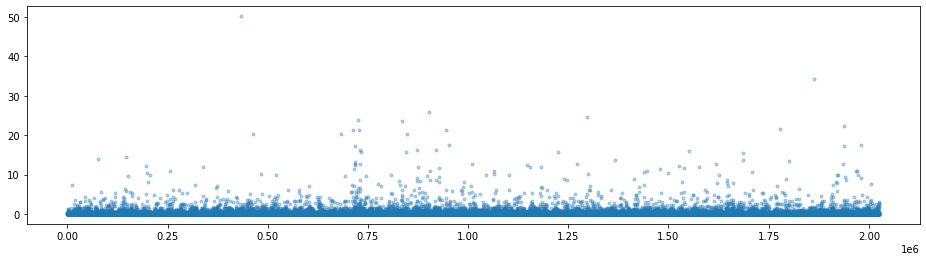

In [9]:
# Target variable spead
plt.figure(figsize=[16,4])
# plt.ylim([0,15])
plt.scatter(X_train.index[::50], y_train_scl[::50], marker=".", alpha=0.33)

# NN Model

## Functional KERAS Archictecture

Using Resnet's "Residual" network idea, we connnect the input layers to the output layer near the end.

In [46]:
from keras import backend as K
from tensorflow.python.ops import math_ops

y_mean_total = tf.constant(y_train_scl.mean(), dtype=np.float32)

def score_loss(y_true, y_pred):
    mse = tf.keras.losses.MSE(y_true, y_pred)
    
    rrmse = K.sqrt(mse) / y_mean_total
    cf = K.mean(K.clip(y_pred-(y_true-0.01), 0, 1))
    
    return 0.9 * rrmse + 0.1 * (1-cf)

def mse_cf_loss(y_true, y_pred):
    mse = tf.keras.losses.MSE(y_true, y_pred)
    cf = K.mean(K.clip(y_pred-y_true, 0, 1))
    
    return 0.7 * mse + 0.3 * (1-cf)


In [47]:
nn_dim = len(X.columns) - 3

id_embedding_size = 8
cat_one_embedding_size = 6
cat_two_embedding_size = 10

nn_total_dims = nn_dim + cat_one_embedding_size + cat_two_embedding_size

# NN Inputs
id_input = keras.Input(shape=(1,), name='id_input')
cat_one_input = keras.Input(shape=(1,), name='cat_one_input')
cat_two_input = keras.Input(shape=(1,), name='cat_two_input')
nn_input = keras.Input(shape=(nn_dim,), name='nn_input')

# Embedding and Flatten layers
id_embedding = keras.layers.Embedding((X_train.id.max())+1, id_embedding_size, 
    input_length=1, name='id_embedding',
    embeddings_initializer="he_normal",
    embeddings_regularizer=keras.regularizers.l2(1e-6))(id_input)

cat_one_embedding = keras.layers.Embedding(X_train.categoria_uno_int.max()+1, cat_one_embedding_size, 
    input_length=1, name='catone_embedding',
    embeddings_initializer="he_normal",
    embeddings_regularizer=keras.regularizers.l2(1e-6))(cat_one_input)

cat_two_embedding = keras.layers.Embedding(X_train.categoria_dos.max()+1, cat_two_embedding_size, 
    input_length=1, name='cattwo_embedding',
    embeddings_initializer="he_normal",
    embeddings_regularizer=keras.regularizers.l2(1e-6))(cat_two_input)


# Concatenate to single vector
concatenated = keras.layers.Concatenate(name="concat_vector")([
    keras.layers.Flatten()(id_embedding),
    keras.layers.Flatten()(cat_one_embedding),
    keras.layers.Flatten()(cat_two_embedding),
    keras.layers.Flatten()(nn_input)
])

# Dense Blocks
current_layer = concatenated

for i in range(2,5):
#     dense_block = keras.layers.BatchNormalization()(current_layer)
    dense_block = keras.layers.Dropout(0.05)(current_layer)
    dense_block = keras.layers.Dense(nn_total_dims * (128/i), activation="relu")(dense_block)
    # dense_block = keras.layers.LeakyReLU(alpha=0.3)(dense_block)
    
    current_layer = dense_block

# Final classifier
dense_final = keras.layers.Dense(nn_total_dims * 8, activation="relu", name="dense_final")(current_layer)
dense_final = keras.layers.Dense(nn_total_dims * 4, activation="relu", name="dense_final2")(dense_final)

# Bypass layers from before
bypass_concat = keras.layers.Concatenate(name="bypass")([
    dense_final,
    keras.layers.Dense(nn_total_dims)(concatenated)
])


output = keras.layers.Dense(1, activation="linear", name="output")(bypass_concat)

model = keras.Model(
    inputs = [
        id_input,
        cat_one_input,
        cat_two_input,
        nn_input
    ],
    outputs = output,
)
model.summary()

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
id_input (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
cat_one_input (InputLayer)      [(None, 1)]          0                                            
__________________________________________________________________________________________________
cat_two_input (InputLayer)      [(None, 1)]          0                                            
__________________________________________________________________________________________________
id_embedding (Embedding)        (None, 1, 8)         3669288     id_input[0][0]                   
_______________________________________________________________________________________

### Final model setup

In [48]:
model.compile(loss=mse_cf_loss, optimizer=keras.optimizers.Adam(lr=0.01), metrics=["mse", score_loss])

# Early Stopping
es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
# Store best model
mc = keras.callbacks.ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

train_data = [
    X_train.id,
    X_train.categoria_uno_int,
    X_train.categoria_dos,
    X_train[X_train.columns.drop(['id','categoria_uno_int', 'categoria_dos'])]
]
test_data = [
    X_test.id,
    X_test.categoria_uno_int,
    X_test.categoria_dos,
    X_test[X_test.columns.drop(['id','categoria_uno_int', 'categoria_dos'])]
]

### Model Training

In [49]:
# Train model
history = model.fit(train_data, y_train_scl, epochs=1000, batch_size=256,
    callbacks=[es, mc],
    validation_data=(test_data, y_test_scl)
)

Epoch 1/1000
7121/7121 [==============================] - ETA: 0s - loss: 2.7986 - mse: 3.6727 - score_loss: 1.5560
Epoch 00001: val_loss improved from inf to 0.96849, saving model to best_model.h5
7121/7121 [==============================] - 123s 17ms/step - loss: 2.7986 - mse: 3.6727 - score_loss: 1.5560 - val_loss: 0.9685 - val_mse: 1.0535 - val_score_loss: 1.3961
Epoch 2/1000
7119/7121 [============================>.] - ETA: 0s - loss: 0.8778 - mse: 0.9276 - score_loss: 1.4598
Epoch 00002: val_loss improved from 0.96849 to 0.94660, saving model to best_model.h5
7121/7121 [==============================] - 122s 17ms/step - loss: 0.8777 - mse: 0.9275 - score_loss: 1.4598 - val_loss: 0.9466 - val_mse: 1.0119 - val_score_loss: 1.3958
Epoch 3/1000
7119/7121 [============================>.] - ETA: 0s - loss: 0.8342 - mse: 0.8646 - score_loss: 1.4513
Epoch 00003: val_loss improved from 0.94660 to 0.93367, saving model to best_model.h5
7121/7121 [==============================] - 119s 17ms

## Old Neural Network architecture

In [ ]:
from keras.layers import Dense, Dropout, BatchNormalization

FEAT_DIM = len(X.columns)

gc.collect()

model = models.Sequential()

model.add(Dense(FEAT_DIM*8, input_dim=FEAT_DIM, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(FEAT_DIM*6, activation='relu'))
model.add(Dropout(0.1))

# model.add(BatchNormalization())
model.add(Dense(FEAT_DIM*5, activation='relu'))
model.add(Dense(FEAT_DIM*4, activation='relu'))
model.add(Dense(FEAT_DIM*3, activation='relu'))
model.add(Dense(FEAT_DIM*2, activation='relu'))
# model.add(Dense(FEAT_DIM*16, activation='relu'))
# OUTPUT
model.add(Dense(1, activation="linear"))


# Early Stopping
es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)
# es = keras.callbacks.EarlyStopping(monitor='val_auc', mode='max', verbose=1, patience=50)
# Store best model
mc = keras.callbacks.ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

model.compile(loss="mae", optimizer='adam', metrics=[])
model.summary()

In [ ]:
history = model.fit(X_train_scl, y_train_scl, epochs=1000, batch_size=200,
    callbacks=[es, mc],
    validation_data=(X_test_scl, y_test_scl)
)

## Plot the NN training results

This plot will help us identify if our NN is overfitting or if the training stalled. We can see a smooth curve downwards indicating our NN trained nicely.

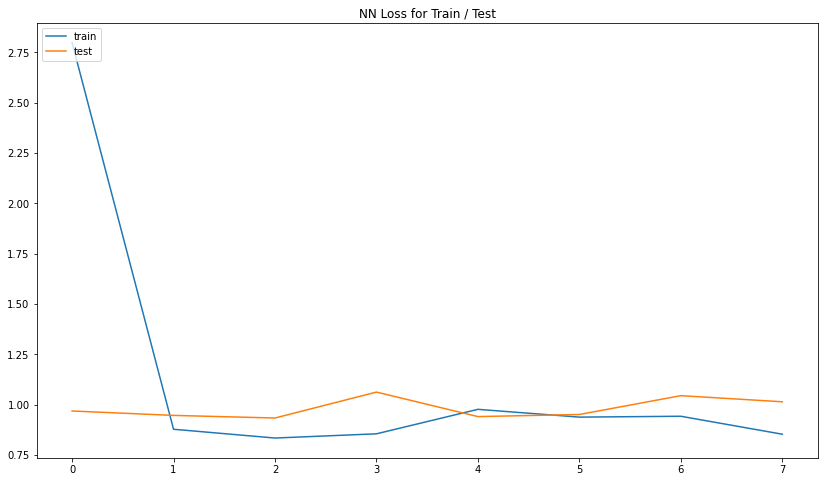

In [50]:
plt.figure(figsize=[14,8])
# plt.ylim((0.85,0.98))

plt.title('NN Loss for Train / Test')

train_acc = history.history['loss']
test_acc = history.history['val_loss']

plt.plot(train_acc)
plt.plot(test_acc)
# plt.plot([max(train_acc)] * len(train_acc))
# plt.plot([max(test_acc)] * len(test_acc))

plt.legend(['train', 'test'], loc='upper left')

## Model Scoring

Before we execute our model with the `Estimar` dataset, lets check the expected performance of our model. We want to center our attention to two aspects:

1. General predictive power across the entire year
2. Predictive score around the interest interval of Black friday and Christmas.
    - This will be the most correlated value to our expected `Estimar` score.

### Scoring Functions

These were defined in the documentation for this project.

In [17]:
def rrmse(y,yhat):
    return np.sqrt(np.sum(np.power(y-yhat,2))/y.shape[0])/y.mean()

def cf(y,yhat):
    no_rotura=np.where(yhat >= y, 1, 0)
    return no_rotura.mean()

def score(y,yhat):
    return (0.7*rrmse(y,yhat))+(.3*(1-cf(y,yhat)))

#### Use Trained model as is

In [51]:
# trained_model = model
y_hat = model.predict(test_data)
y_hat_real = y_scaler.inverse_transform(y_hat)

#### Load Best model

In [ ]:
from keras.models import load_model

best_model = load_model('best_model.h5', compile = False)

y_hat = best_model.predict(X_test)
y_hat_real = y_scaler.inverse_transform(y_hat)

### General error over the range

3.204192696509518

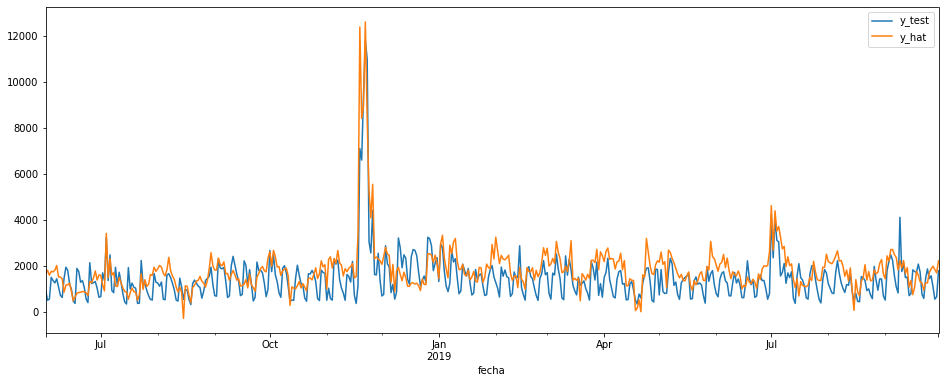

In [54]:
df_y_hat = pd.DataFrame()

df_y_hat['fecha'] = df_modelar.loc[X_test.index].fecha
# df_y_hat['visitas'] = X_test.visitas_scl
df_y_hat['y_test'] = y_test
df_y_hat['y_hat'] = ((y_hat_real * 1.0).round(0) ) * 1 + 0

df_y_hat.groupby('fecha').sum().plot(figsize=[16,6])

# y_hat_real += np.where(y_hat_real <= 0, 1, 1)
score(df_y_hat.y_test, df_y_hat.y_hat)

### Black Friday OOS Test

3.8150594190880183

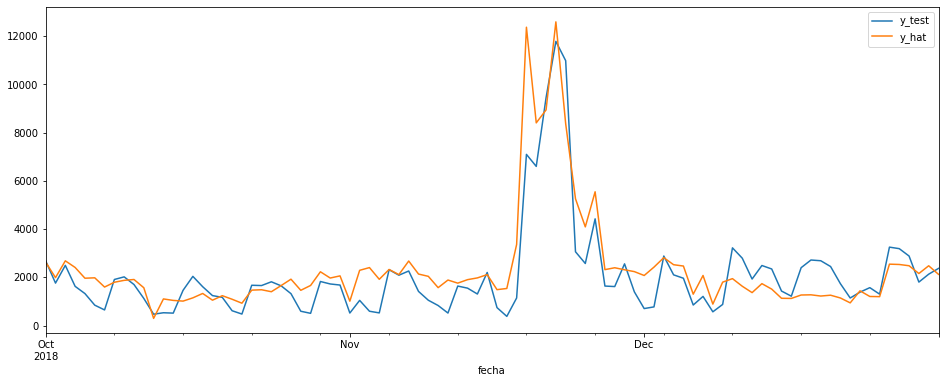

In [55]:
# Black friday dates
bf_index = (df_y_hat.fecha >= datetime(2018,10,1)) & (df_y_hat.fecha <= datetime(2018,12,31))

df_bf = df_y_hat[bf_index]
df_bf.groupby('fecha').sum().plot(figsize=[16,6])

score(df_bf.y_test, df_bf.y_hat)

# Generate final predictions

Apply the same transformations to the `Estimar` dataset to match the training data and generate predictions for it. We adjust the final output by +1 due to the `CF` factor.

In [24]:
X_estimar = df_estimar[X_cols]
X_estimar[X_cols_to_scl] = X_scaler.transform(X_estimar[X_cols_to_scl])

In [27]:
estimar_data = [
    X_estimar.id,
    X_estimar.categoria_uno_int,
    X_estimar.categoria_dos,
    X_estimar[X_test.columns.drop(['id','categoria_uno_int', 'categoria_dos'])]
]

y_estimar = model.predict(estimar_data)

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type int).

In [25]:
y_estimar = best_model.predict(X_estimar.astype(float))
y_estimar = y_scaler.inverse_transform(y_estimar)

y_estimar = y_estimar.round(0) + 1

AssertionError: in user code:

    c:\users\herman\nextcloud\documents\hackathon\cajamar datalab 2021\env\lib\site-packages\tensorflow\python\keras\engine\training.py:1462 predict_function  *
        return step_function(self, iterator)
    c:\users\herman\nextcloud\documents\hackathon\cajamar datalab 2021\env\lib\site-packages\tensorflow\python\keras\engine\training.py:1452 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    c:\users\herman\nextcloud\documents\hackathon\cajamar datalab 2021\env\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    c:\users\herman\nextcloud\documents\hackathon\cajamar datalab 2021\env\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    c:\users\herman\nextcloud\documents\hackathon\cajamar datalab 2021\env\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    c:\users\herman\nextcloud\documents\hackathon\cajamar datalab 2021\env\lib\site-packages\tensorflow\python\keras\engine\training.py:1445 run_step  **
        outputs = model.predict_step(data)
    c:\users\herman\nextcloud\documents\hackathon\cajamar datalab 2021\env\lib\site-packages\tensorflow\python\keras\engine\training.py:1418 predict_step
        return self(x, training=False)
    c:\users\herman\nextcloud\documents\hackathon\cajamar datalab 2021\env\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:985 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    c:\users\herman\nextcloud\documents\hackathon\cajamar datalab 2021\env\lib\site-packages\tensorflow\python\keras\engine\functional.py:386 call
        inputs, training=training, mask=mask)
    c:\users\herman\nextcloud\documents\hackathon\cajamar datalab 2021\env\lib\site-packages\tensorflow\python\keras\engine\functional.py:517 _run_internal_graph
        assert x_id in tensor_dict, 'Could not compute output ' + str(x)

    AssertionError: Could not compute output Tensor("output/BiasAdd_1:0", shape=(None, 1), dtype=float32)


In [50]:
df_entrega = df_estimar[['fecha','id']]
df_entrega['unidades'] = y_estimar.astype(int)

# df_entrega.loc[df_entrega.fecha.dt.year == 2019, "fecha"] = df_entrega.fecha + pd.offsets.DateOffset(year=2016)
df_entrega[:5]

,fecha,id,unidades
0,2019-10-01,21972,1
1,2019-10-02,21972,1
2,2019-10-03,21972,1
3,2019-10-04,21972,1
4,2019-10-05,21972,1


In [45]:
df_entrega

,fecha,id,unidades
0,2016-10-01,21972,1
1,2016-10-02,21972,1
2,2016-10-03,21972,1
3,2016-10-04,21972,1
4,2016-10-05,21972,1
...,...,...,...
212836,2016-12-26,458660,13
212837,2016-12-27,458660,9
212838,2016-12-28,458660,7
212839,2016-12-29,458660,4


In [65]:
mask = df_modelar.id.isin(df_estimar.id)

df_modelar_sameid.shape, df_modelar.shape

((1335090, 170), (1555803, 170))

In [76]:
df_modelar_fixed = df_modelar_sameid.groupby(['fecha','id']).max().reset_index()

<AxesSubplot:xlabel='fecha'>

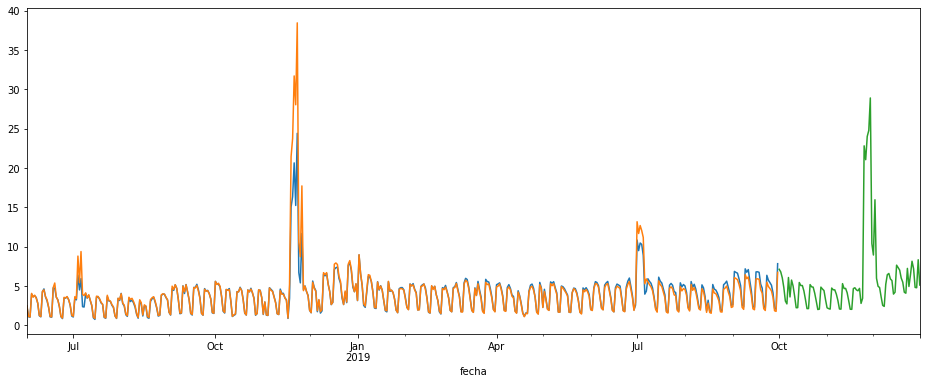

In [80]:
plt.figure(figsize=[16,6])

df_modelar_fixed.groupby('fecha').mean().unidades_vendidas.plot()
df_modelar.groupby('fecha').mean().unidades_vendidas.plot()
(df_entrega.groupby('fecha').mean().unidades *1).plot()

## Delivery CSV

In [105]:
df_entrega.columns = ['FECHA', 'ID', 'UNIDADES']
df_entrega.to_csv('data/Equip Autoestima.txt', sep='|', index=False, date_format="%d/%m/%Y")